In [1]:
import os
import argparse

# import nest_asyncio
import numpy as np
import pandas as pd
import lightkurve as lk
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.io import fits
from tqdm import tqdm
from astrocut import CutoutFactory
from ipywidgets import *
import matplotlib.colors as colors
from matplotlib import patches

from tess_asteroid_ml import *
from tess_asteroid_ml.make_TESS_asteroid_db import *
from tess_asteroid_ml.utils import in_cutout, power_find

/Users/jorgemarpa/.pyenv/versions/tess-asteroids-v2/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/jorgemarpa/.lightkurve/cache. Please move all the files in the legacy directory /Users/jorgemarpa/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
from tess_asteroid_ml.make_TESScut_asteroids import *

In [38]:
sector = 4
camera = 1
ccd = 3 
provider = "mast"
maglim = 20

In [39]:
ffi_file = get_FFI_name(sector=sector, camera=camera, ccd=ccd, provider=provider, correct=False)
ffi_file

['https://archive.stsci.edu/missions/tess/ffi/s0004/2018/307/1-3/tess2018307065939-s0004-1-3-0124-s_ffic.fits']

In [40]:
# get FFI data to build ra/dec coordinates for later query

ffi_header, f2d, col_2d, row_2d, ra_2d, dec_2d = get_data_from_files(
    ffi_file, provider=provider
)
ffi_header = ffi_header[0]
f2d = f2d[0]
col_2d = col_2d
row_2d = row_2d
ra_2d = ra_2d[0]
dec_2d = dec_2d[0]

In [41]:
jpl_df = get_asteroid_table(
    SkyCoord(ra_2d.min() * u.deg, dec_2d.min() * u.deg, frame='icrs'),
    SkyCoord(ra_2d.max() * u.deg, dec_2d.max() * u.deg, frame='icrs'),
    sector=sector,
    camera=camera,
    ccd=0,
)
if maglim <= 30:
    asteroid_df = jpl_df.query(f"V_mag <= {maglim}")
asteroid_df

Loading from CSV file: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/jpl/jpl_small_bodies_tess_s0004-1-0_catalog.csv
JPL SBI found 25424 asteroids with V < 30 in s0004-1-0


,Object name,Astrometric RA (hh:mm:ss),"Astrometric Dec (dd mm'ss"")","Dist. from center RA ("")","Dist. from center Dec ("")","Dist. from center Norm ("")",Visual magnitude (V),"RA rate (""/h)","Dec rate (""/h)",ra,dec,V_mag,name,id
0,23 Thalia (A852 XA),02:17:25.72,+04:42:15.7,-30000.0,30000.0,38000.0,10.4,-42.45,-3.117000,34.357167,4.704361,10.4,23 Thalia,A852 XA
1,46 Hestia (A857 QA),02:06:33.37,+10:07:53.4,-40000.0,50000.0,59000.0,11.0,-36.38,-13.680000,31.639042,10.131500,11.0,46 Hestia,A857 QA
2,307 Nike (A891 EB),01:53:36.72,+01:45:59.6,-50000.0,20000.0,51000.0,13.6,-33.81,-6.223000,28.403000,1.766556,13.6,307 Nike,A891 EB
3,318 Magdalena (A891 SA),01:49:45.16,-01:12:56.6,-50000.0,6000.0,52000.0,14.1,-28.23,-11.980000,27.438167,-1.215722,14.1,318 Magdalena,A891 SA
4,381 Myrrha (A894 AC),03:26:13.42,+01:00:51.5,30000.0,10000.0,37000.0,13.5,-29.41,-8.065000,51.555917,1.014306,13.5,381 Myrrha,A894 AC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22430,(2018 XC20),03:11:38.13,-04:16:49.4,20000.0,-6000.0,22000.0,19.6,-28.15,-13.830000,47.908875,-4.280389,19.6,NaN,2018 XC20
22437,(2019 AX7),02:37:47.20,-05:40:56.2,-9000.0,-10000.0,14000.0,19.4,-28.80,-34.340000,39.446667,-5.682278,19.4,NaN,2019 AX7
25391,(2023 RJ4),03:28:25.45,-02:45:49.2,40000.0,-46.9,37000.0,20.0,-37.18,-0.006932,52.106042,-2.763667,20.0,NaN,2023 RJ4
25409,243P/NEAT,01:52:15.73,+00:27:24.0,-50000.0,10000.0,51000.0,17.9N,-28.86,-0.072830,28.065542,0.456667,17.9,243P/NEAT,243P/NEAT


In [42]:
sb_ephems_lowres = read_asteroid_db(
    asteroid_df, low_res=True, sector=sector, camera=1, ccd=3
)

In [43]:
vlo, lo, mid, hi, vhi = np.nanpercentile(f2d, [0.2, 3, 50, 95, 99])
cnorm = colors.LogNorm(vmin=lo, vmax=vhi)

In [44]:
len(sb_ephems_lowres)

1710

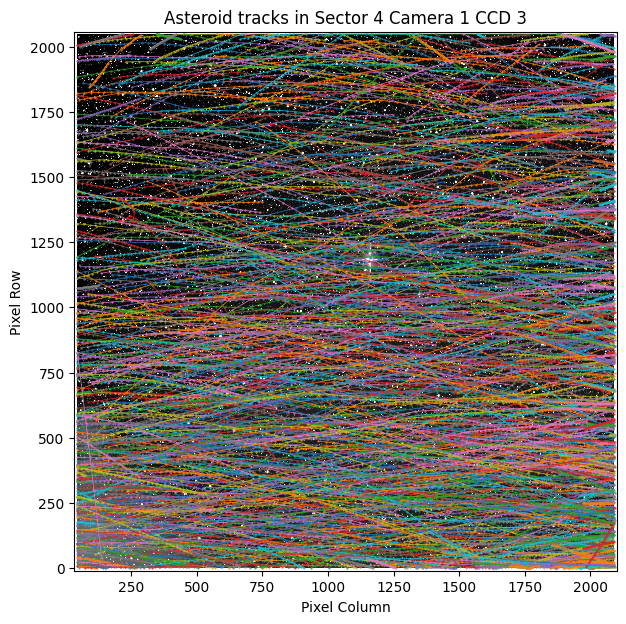

In [45]:
plt.figure(figsize=(7,7))
plt.title(f"Asteroid tracks in Sector {sector} Camera {camera} CCD {ccd}")
plt.pcolormesh(col_2d, row_2d, f2d, norm=cnorm, cmap="Greys_r")

for k, val in sb_ephems_lowres.items():
    if len(val) == 0:
        continue
    val = val.query(f"camera == {camera} and ccd == {ccd}")
    plt.plot(val.column, val.row, ".-", ms=1., lw=.5)
    # if k == 1: break

plt.xlim(col_2d.min() - 10, col_2d.max() + 10)
plt.ylim(row_2d.min() - 10, row_2d.max() + 10)
# plt.gca().set_aspect('equal')
plt.xlabel("Pixel Column")
plt.ylabel("Pixel Row")
plt.show()

In [46]:
cutout_size = 64
xcen, ycen = get_cutout_centers(sampling="tiled", overlap=5, size=cutout_size)
xcen, ycen, xcen.shape

(array([[  34,   93,  152, ..., 1863, 1922, 1981],
        [  34,   93,  152, ..., 1863, 1922, 1981],
        [  34,   93,  152, ..., 1863, 1922, 1981],
        ...,
        [  34,   93,  152, ..., 1863, 1922, 1981],
        [  34,   93,  152, ..., 1863, 1922, 1981],
        [  34,   93,  152, ..., 1863, 1922, 1981]]),
 array([[  34,   34,   34, ...,   34,   34,   34],
        [  93,   93,   93, ...,   93,   93,   93],
        [ 152,  152,  152, ...,  152,  152,  152],
        ...,
        [1863, 1863, 1863, ..., 1863, 1863, 1863],
        [1922, 1922, 1922, ..., 1922, 1922, 1922],
        [1981, 1981, 1981, ..., 1981, 1981, 1981]]),
 (34, 34))

In [47]:
import warnings
warnings.simplefilter('ignore')

In [48]:
sb_ephems_highres = {}

In [ ]:
fficuts_list = []

for nrow, i in enumerate(ycen[1:, 0]):
    # if not (i < 200 or i > 1800):
    #     continue
    if nrow == 22:
        sb_ephems_highres = {}
    F, X, Y, L = [], [], [], []
    cut_dict = {}
    for j in xcen[0, 1:]:
        # if not (j < 200 or j > 1800):
        #     continue
        cut_dict[f"c{col_2d[i, j]:04}_r{row_2d[i,j]:04}"] = SkyCoord(
            ra_2d[i, j] * u.deg, dec_2d[i, j] * u.deg, frame="icrs"
        )
        # if j > 1000: break
    
    print(f"Working with row {nrow + 1}/{len(ycen[1:, 0])} and {len(cut_dict)} cuts...")
        
    tpf_names = get_cutouts(
            cut_dict,
            sector=sector,
            cam_ccd=f"{camera}-{ccd}",
            cutout_size=cutout_size,
        )

    for k, ff in tqdm(enumerate(tpf_names), 
                      total=len(tpf_names), 
                      desc=f"TESS cut files row {nrow + 1}", ):

        fficut_aster = AsteroidTESScut(lk.read(ff))
        fficut_aster.ffi_exp_time = (ffi_header["TSTOP"] - ffi_header["TSTART"]) * 24 * 3600
        fficut_aster.get_CBVs(align=False, interpolate=True)

        for k, val in sb_ephems_lowres.items():
            if len(val) == 0:
                continue
            # check if asteroid track passes over the TESScut
            is_in = in_cutout(
                fficut_aster.column,
                fficut_aster.row,
                sb_ephems_lowres[k].column.values,
                sb_ephems_lowres[k].row.values,
            )
            if is_in:
                # print(
                #     f"({k}) Asteroid in cutout: ", asteroid_df.loc[k, "name"]
                # )
                # load full res track
                if k not in sb_ephems_highres.keys():
                    sb_ephems_highres.update(read_asteroid_db(
                        asteroid_df.loc[[k]],
                        low_res=False,
                        sector=sector,
                        camera=camera,
                        ccd=ccd,
                    ))
                source_rad = 2.5e2 / (sb_ephems_highres[k].vmag.mean()) ** 1.8
                fficut_aster.get_asteroid_mask(
                    sb_ephems_highres[k],
                    name=asteroid_df.loc[k, "Object name"],
                    mask_type="circular",
                    mask_radius=source_rad,
                )
        F.append(fficut_aster.flux_2d)
        X.append(fficut_aster.column_2d[0, 0])
        Y.append(fficut_aster.row_2d[0, 0])
        L.append(fficut_aster.asteroid_mask_2d)
        # fficut_aster.save_data()
        
        if fficut_aster.asteroid_mask_2d is None:
            break
        
        # if np.random.choice([1,1]):
        #     fficuts_list.append(fficut_aster)

        # break
    # if nrow > 2: break
    
    F, X, Y, L = np.array(F), np.array(X), np.array(Y), np.array(L)
    out_path = f"{os.path.dirname(PACKAGEDIR)}/data/asteroidcuts/sector{sector:04}"
    if not os.path.isdir(out_path):
        os.makedirs(out_path)
    out_file = f"{out_path}/tess-asteroid-cuts_{cutout_size}x{cutout_size}_s{sector:04}-{camera}-{ccd}_{nrow:02}.npz"
    np.savez(out_file, 
         flux=F,
         column=X, 
         row=Y, 
         mask=L.astype(bool), 
         time=fficut_aster.time, 
         cbv=fficut_aster.cbvs
        )

Working with row 1/33 and 33 cuts...


TESS cut files row 1: 100%|███████████████████████████████████████████████████████████| 33/33 [03:37<00:00,  6.59s/it]


Working with row 2/33 and 33 cuts...


TESS cut files row 2: 100%|███████████████████████████████████████████████████████████| 33/33 [03:27<00:00,  6.30s/it]


Working with row 3/33 and 33 cuts...


TESS cut files row 3:  45%|██████████████████████████▊                                | 15/33 [01:30<01:44,  5.80s/it]

In [51]:
fficut_aster.asteroid_names

{1: '5479 Grahamryder (1989 UT5)',
 2: '6251 Setsuko (1992 DB)',
 4: '7803 Adachi (1997 EW2)',
 8: '26171 (1996 BY2)',
 16: '32727 (4268 T-3)',
 32: '47171 Lempo (1999 TC36)',
 64: '56380 (2000 EJ43)',
 128: '57917 (2002 EK111)',
 256: '66403 (1999 LM13)',
 512: '71820 (2000 UF24)',
 1024: '81582 (2000 HZ45)',
 2048: '82794 (2001 QN25)',
 4096: '97065 (1999 VV20)',
 8192: '98314 (2000 SA259)',
 16384: '105632 (2000 SQ8)',
 32768: '129176 Gerardcarter (2005 LM2)',
 65536: '136504 (2005 JX153)',
 131072: '146492 (2001 SB20)',
 262144: '155444 (1998 HJ35)',
 524288: '166082 (2002 CR106)',
 1048576: '166222 (2002 FY3)',
 2097152: '166877 (2002 XG61)',
 4194304: '173036 (2006 QR51)',
 8388608: '197144 (2003 UX255)',
 16777216: '199119 (2005 YF77)',
 33554432: '201708 (2003 UJ163)',
 67108864: '214323 (2005 JW55)',
 134217728: '218985 (2008 GU104)',
 268435456: '224918 (2007 DZ27)',
 536870912: '225039 (2007 GY4)',
 1073741824: '243792 (2000 SM81)',
 2147483648: '270217 (2001 TB149)'}

In [52]:
fficut_aster.asteroid_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [63]:
np.abs(np.unique(fficut_aster.asteroid_mask).astype(np.int64))

array([2147483648,          0,          1,          2,          4,
                8,         16,         32,         64,        128,
              256,        512,       1024,       2048,       4096,
             8192,      16384,      32768,      65536,     131072,
           262144,     294912,     524288,    1048576,    2097152,
          4194304,    8388608,   16777216,   33554432,   67108864,
        134217728,  268435456,  536870912, 1073741824])

In [65]:
multiple_asteroid = [x for x in np.abs(np.unique(fficut_aster.asteroid_mask).astype(np.int64)) if len(power_find(x)) > 1]
multiple_asteroid

[294912]

In [14]:
fficut_aster = fficuts_list[-2]

IndexError: list index out of range

In [98]:
time_idx = np.unique(np.hstack([x for x in fficut_aster.asteroid_time_idx.values()]))
fficut_aster.asteroid_names, fficut_aster.asteroid_time_idx

({1: '5588 Jennabelle (1990 SW3)',
  2: '25762 (2000 CO2)',
  4: '27221 (1999 FA27)',
  8: '63539 (2001 PH39)'},
 {1: array([150, 151, 152, 153, 154, 155, 156, 157]),
  2: array([ 936,  937,  938,  939,  940,  941,  942,  943,  944,  945,  946,
          947,  948,  949,  950,  951,  952,  953,  954,  955,  956,  957,
          958,  959,  960,  961,  962,  963,  964,  965,  966,  967,  968,
          969,  970,  971,  972,  973,  974,  975,  976,  977,  978,  979,
          980,  981,  982,  983,  984,  985,  986,  987,  988,  989,  990,
          991,  992,  993,  994,  995,  996,  997,  998,  999, 1000, 1001,
         1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012,
         1013, 1014, 1015]),
  4: array([215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227,
         228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240,
         241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
         254, 255, 256, 257, 258, 259, 260, 261, 26

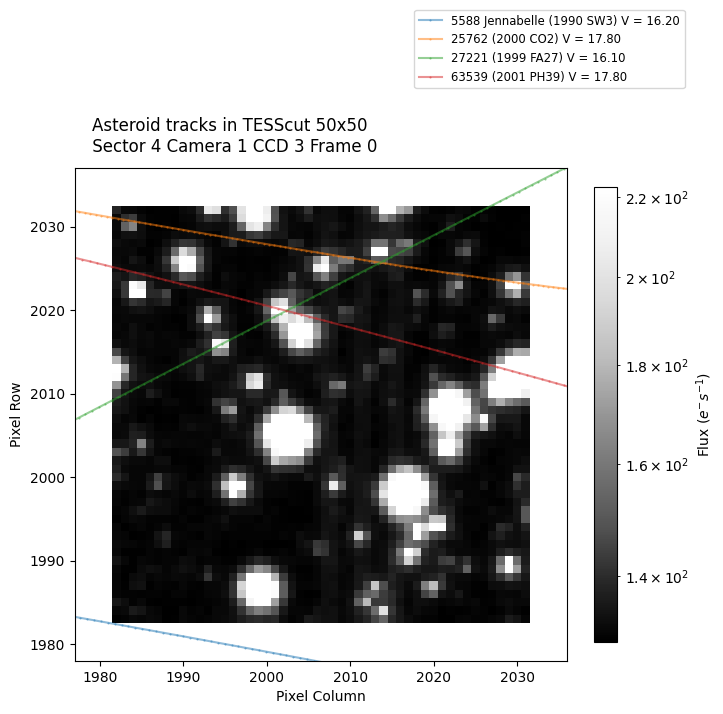

interactive(children=(IntSlider(value=78, description='frame', max=1035, min=78), Output()), _dom_classes=('wi…

In [99]:
frame = 0

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
fig.suptitle(f"Asteroid tracks in TESScut 50x50 \n "
             f"Sector {sector} Camera {camera} CCD {ccd} Frame {frame}", 
             y=0.92, x=0.35)

vlo, lo, hi, vhi = np.nanpercentile(fficut_aster.flux_2d[frame], [0.2, 1, 95, 99.8])
cnorm = colors.SymLogNorm(linthresh=200, vmin=100, vmax=1000, base=10)
cnorm = colors.LogNorm(vmin=lo, vmax=hi)

# cnorm = colors.LogNorm(vmin=10, vmax=100)
ima = ax.pcolormesh(fficut_aster.column_2d, 
                        fficut_aster.row_2d,
                        fficut_aster.flux_2d[frame],
                   cmap="Greys_r",
                   norm=cnorm,
                   )
plt.colorbar(
    ima, ax=ax, label=r"Flux ($e^{-}s^{-1}$)", fraction=0.042
    )

aperture_mask = fficut_aster.asteroid_mask_2d[frame]

names_in_cut = pd.concat([asteroid_df[asteroid_df["Object name"] == v] 
                          for v in fficut_aster.asteroid_names.values()]).index

for k in names_in_cut:
    ax.plot(sb_ephems_highres[k].column, 
             sb_ephems_highres[k].row, 
             ".-", 
             ms=1,
             # c="tab:green",
             alpha=.5,
             label=f"{asteroid_df.loc[k, 'Object name']} V = {asteroid_df.loc[k, 'V_mag']:.2f}")

ax.set_xlim(fficut_aster.column.min() - 5,fficut_aster.column.max() + 5)
ax.set_ylim(fficut_aster.row.min() - 5,fficut_aster.row.max() + 5)
ax.set_aspect("equal")
ax.set_xlabel("Pixel Column")
ax.set_ylabel("Pixel Row")
ax.legend(fontsize="small", bbox_to_anchor=(1.25, 1.15))


@widgets.interact(frame=(time_idx.min(), time_idx.max()+20, 1))
def update(frame=0):
    ax.pcolormesh(fficut_aster.column_2d, 
                  fficut_aster.row_2d,
                  fficut_aster.flux_2d[frame],
                   cmap="Greys_r",
                   norm=cnorm,
                   )
    aperture_mask = fficut_aster.asteroid_mask_2d[frame]
    for i in range(aperture_mask.shape[0]):
        for j in range(aperture_mask.shape[1]):
            if aperture_mask[i, j]:
                rect = patches.Rectangle(
                    xy=(j + fficut_aster.column.min() - 0.5, i + fficut_aster.row.min() - 0.5),
                    width=1,
                    height=1,
                    color="tab:red",
                    fill=False,
                    hatch="",
                    alpha=.5
                )
                ax.add_patch(rect)
    
    fig.suptitle(f"Asteroid tracks in TESScut 50x50 \n "
                 f"Sector {sector} Camera {camera} CCD {ccd} Frame {frame}",
                 y=0.92, x=0.35)
    return fig
